# Examples

This Jupyter notebook shows some examples for the different functions of the Matlab class `zaf`.

Functions:
- [`stft`](#stft) - Compute the short-time Fourier transform (STFT).
- [`istft`](#istft) - Compute the inverse STFT.
- [`cqtkernel`](#cqtkernel) - Compute the constant-Q transform (CQT) kernel.
- [`cqtspectrogram`](#cqtspectrogram) - Compute the CQT spectrogram using a CQT kernel.
- [`cqtchromagram`](#cqtchromagram) - Compute the CQT chromagram using a CQT kernel.
- [`mfcc`](#mfcc) - Compute the mel frequency cepstrum coefficients (MFCCs).
- [`dct`](#dct) - Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
- [`dst`](#dst) - Compute the discrete sine transform (DST) using the FFT.
- [`mdct`](#mdct) - Compute the modified discrete cosine transform (MDCT) using the FFT.
- [`imdct`](#imdct) - Compute the inverse MDCT using the FFT.

Other:
- `sigplot` - Plot a signal in seconds.
- `specshow` - Display a spectrogram in dB, seconds, and Hz.
- `cqtspecshow` - Display a CQT spectrogram in dB, seconds, and Hz.
- `cqtchromshow` - Display a CQT chromagram in seconds.


Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 12/06/20

## <a id="stft"></a>stft

Compute the short-time Fourier transform (STFT).

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_stft: audio STFT (window_length, number_frames)
```

### Example: Compute and display the spectrogram from an audio file.

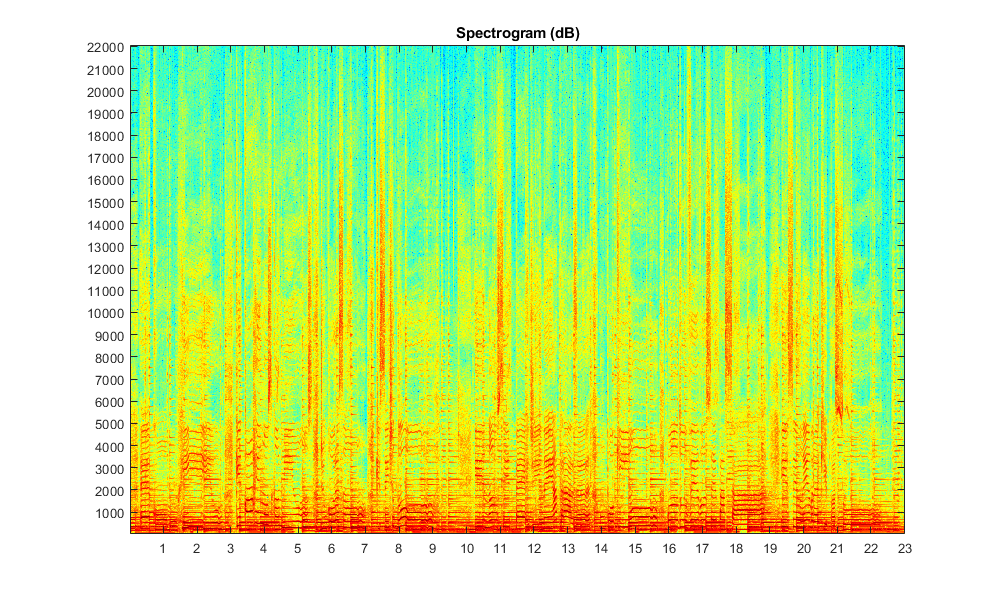

In [59]:
%plot -s 1000,600

% Read the audio signal with its sampling frequency in Hz, and average it over its channels
[audio_signal,sampling_frequency] = audioread('audio_file.wav');
audio_signal = mean(audio_signal,2);

% Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04;

% Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = 2^nextpow2(window_duration*sampling_frequency);

% Compute the window function (periodic Hamming window for COLA)
window_function = hamming(window_length,'periodic');

% Set the step length in samples (half of the window length for COLA)
step_length = window_length/2;

% Compute the STFT
audio_stft = zaf.stft(audio_signal,window_function,step_length);

% Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = abs(audio_stft(2:window_length/2+1,:));

% Display the spectrogram in dB, seconds, and Hz
xtick_step = 1;
ytick_step = 1000;
zaf.specshow(audio_spectrogram, length(audio_signal), sampling_frequency, xtick_step, ytick_step);
title('Spectrogram (dB)')

In [ ]:
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%
%